# Classificação - Satisfação de Passageiro em Linhas Aéreas

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

# 2. Data set - Explicação

Esse data set possui 25 colunas, 24 sendo potenciais features e 1 target (satisfação). Ela é uma variável categórica não ordenada e assume 2 valores: satisfeito ou neutro/insatisfeito. Ainda, a target está bem balanceada, estando divida em 43/57 %

Em relação as features, elas variam entre qualitativas e quantitativas, sendo majoritariamente qualitativas e com poucas linhas com valores faltando.

### Colunas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlp import mlp

df = pd.read_csv('train.csv')

target = df['satisfaction']

df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

### Target bem equilibrada

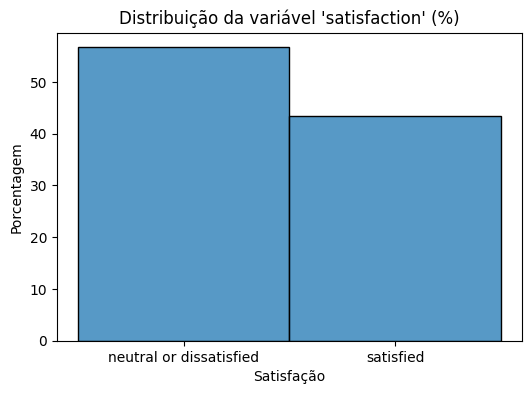

In [3]:
plt.figure(figsize=(6,4))
ax = sns.histplot(x=target, stat="percent", discrete=True)

plt.title("Distribuição da variável 'satisfaction' (%)")
plt.xlabel("Satisfação")
plt.ylabel("Porcentagem")
plt.show()

### Preenchendo valores vazios

In [4]:
print(df.columns[df.isnull().any()]) #observa-se colunas com valores faltando!

Index(['Arrival Delay in Minutes'], dtype='object')


### Arrival delay é numérica, utilizaremos a moda para preencher o valor, já que se arrival delay está como null, provavelmente foi 0 e esqueceram de colocar

In [5]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mode()[0])
print(df.columns[df.isnull().any()]) #roda mais uma vez para garantir

Index([], dtype='object')


### Visualização features

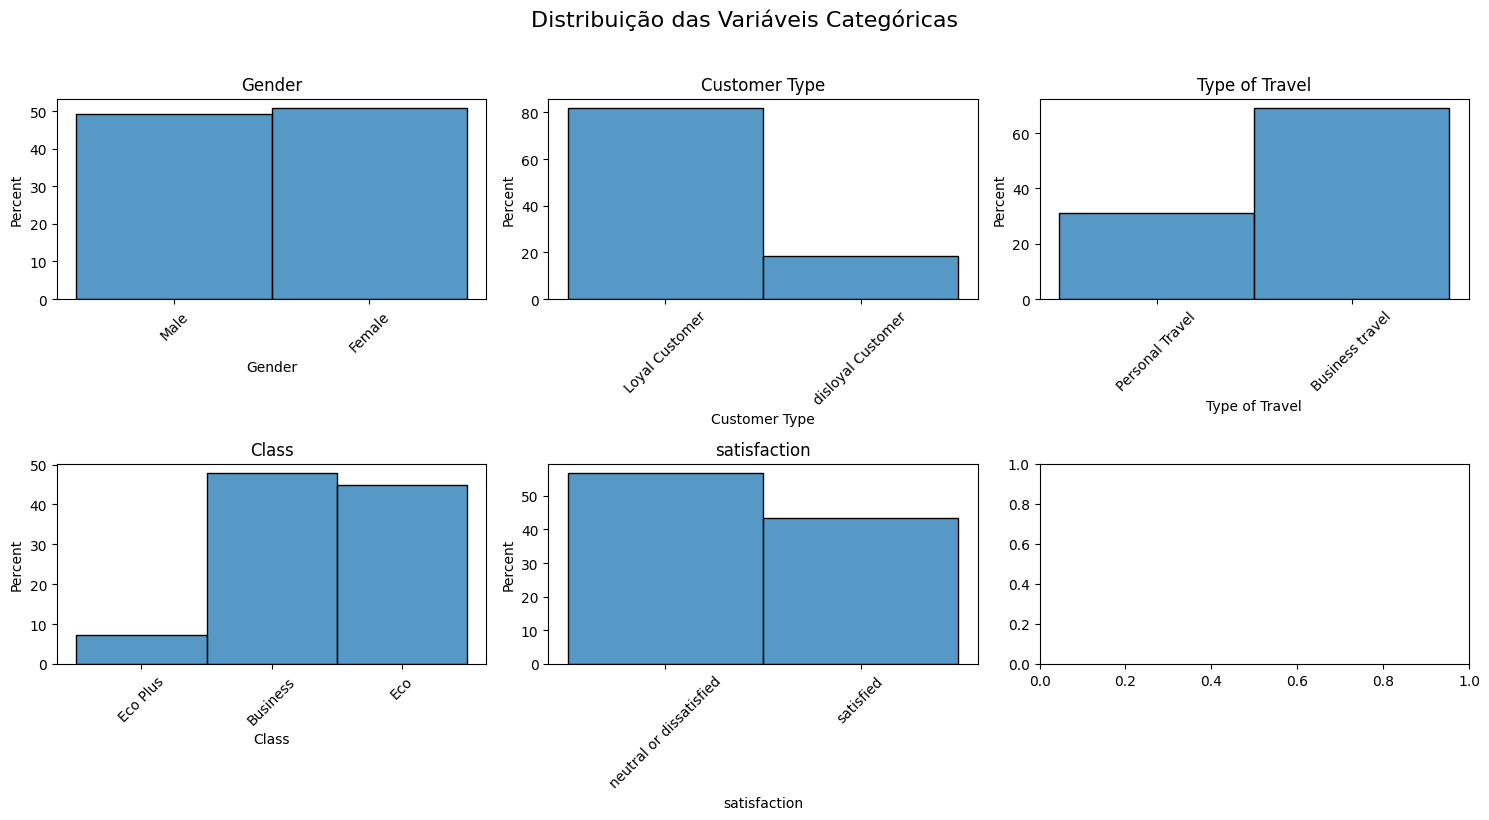

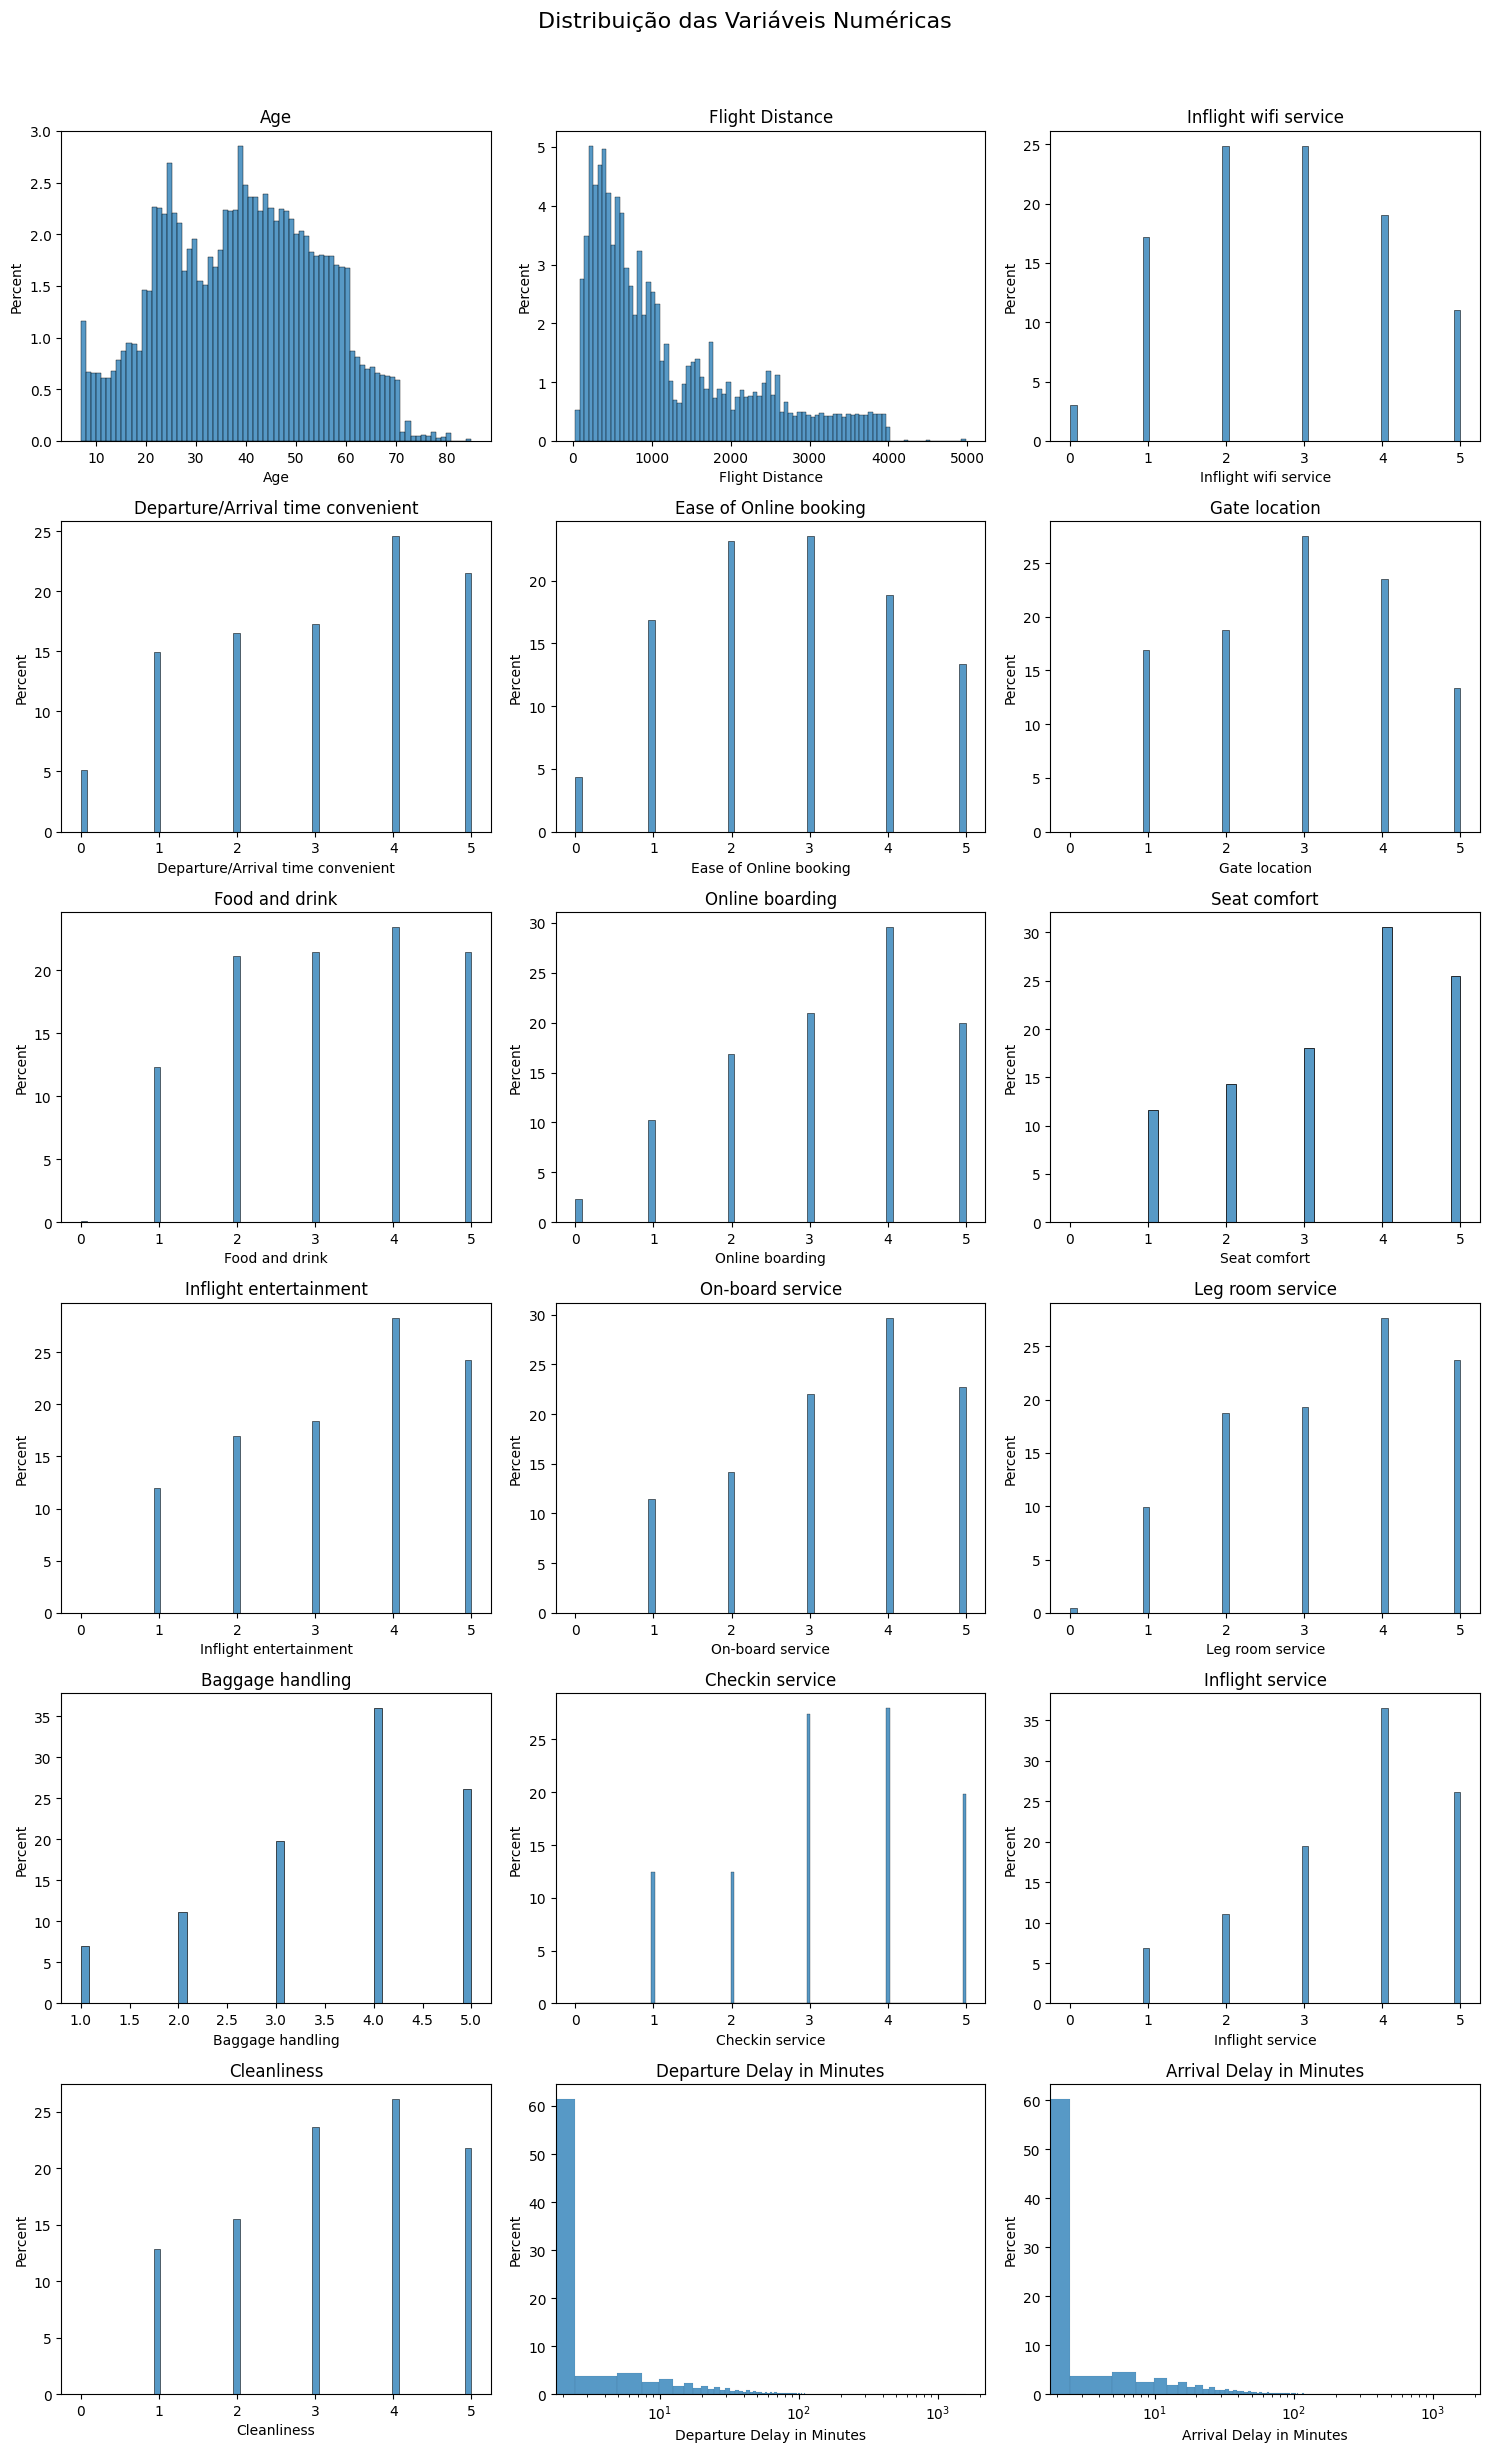

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar dados
df = pd.read_csv("train.csv")

# Separar variáveis categóricas e numéricas
categorical_cols = df.select_dtypes(include=["object"]).columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Remover colunas não úteis
categorical_cols = [col for col in categorical_cols if col not in ["Unnamed: 0", "id"]]
numeric_cols = [col for col in numeric_cols if col not in ["Unnamed: 0", "id"]]

# --- Plot variáveis categóricas ---
n_cat = len(categorical_cols)
n_cols = 3
n_rows = (n_cat + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.histplot(x=df[col], stat="percent", discrete=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Distribuição das Variáveis Categóricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# --- Plot variáveis numéricas ---
n_num = len(numeric_cols)
n_cols = 3
n_rows = (n_num + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=False, ax=axes[i], stat='percent')
    axes[i].set_title(col)

    # Ajuste de escala para atrasos (melhora a legibilidade)
    if "Delay" in col:
        # escala logarítmica no eixo X
        axes[i].set_xscale("log")

fig.suptitle("Distribuição das Variáveis Numéricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Pelas distribuições apresentadas, as variáveis categóricas estão relativamente balanceadas em alguns aspectos, mas apresentam diferenças relevantes em outros. O gênero está equilibrado entre homens e mulheres. Já o tipo de cliente é bastante desbalanceado, com predominância de clientes leais. No tipo de viagem, há mais viagens de negócios do que pessoais. Em relação à classe, as categorias Business e Eco têm proporções próximas, enquanto Eco Plus aparece em bem menor quantidade. A variável de satisfação também é relativamente balanceada, com uma leve maioria de clientes insatisfeitos ou neutros.

Nas variáveis numéricas, observa-se diversidade: a idade segue uma distribuição concentrada entre 20 e 50 anos; a distância do voo é enviesada para valores menores; e os atrasos de partida e chegada apresentam forte concentração em atrasos curtos, com alguns outliers de longos atrasos. Já os serviços avaliativos (como wifi, comida, embarque, conforto de assento, limpeza, etc.) mostram distribuições variadas, mas tendem a concentrar respostas em notas intermediárias a altas, o que sugere certo viés positivo nas avaliações.

# 3. Limpeza de dados e normalização

In [ ]:
# ======= CATEGORICO =======
# GENDER -> DUMMIE
# CUSTOMER TYPE -> DUMMIE
# TYPE OF TRAVEL -> DUMMIE
# SATISFACION -> DUMMIE
# CLASS -> ORDINAL ENCODING

# ======= NUMERICO =======

# AGE -> Z SCORE
# FLIGHT DISTANCE -> MIN/MAX
# WIFI -> Z SCORE
# ...
# TUDO EM Z SCORE MENOS DELAY
# DELAYS -> LOG DEPOIS MIN/MAX

# 4. Implementação MLP

# 5. Treinando Modelo

# 6. Estratégia de treino e teste

# 7. Curva de erro e visualização

# 8. Avaliação do modelo